# Full Dataset Predicitons with OpenAI

In [ ]:
import tiktoken
import pandas as pd
import json
import numpy as np
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from openai import OpenAI
import os


pd.set_option('display.max_rows', 400)


## Count Tokens in Dataset for Cost Estimates

In [ ]:
#Bring in markets dataset with prices 
markets_df = pd.read_feather('Data/markets_df_df_v3.feather')

#Use gpt encoding to count tokens in question and description
encoding = tiktoken.encoding_for_model("gpt-4")

markets_df['question_tokens'] = markets_df['question'].apply(lambda x: len(encoding.encode(x)))
markets_df['descrip_tokens'] = markets_df['description'].apply(lambda x: len(encoding.encode(x)))

display(markets_df.question_tokens.describe())
markets_df.descrip_tokens.describe()


In [ ]:
#count total tokens in qustions and descriptions
question_tokens = markets_df.question_tokens.sum() + markets_df.descrip_tokens.sum()

#System prompt
sys_prompt = """You are an expert forecaster. 
Analyze the following prediction market
and output your prediction as a single 
number between 0 and 1 for the
probability of the first outcome 
listed below."""


sys_tokens = len(encoding.encode(sys_prompt))
sys_tokens = len(encoding.encode(sys_prompt))

input_tokens = (question_tokens + sys_tokens) * len(markets_df)
print(input_tokens / 1000000)


7.981522
1.355145


## Set up Open AI Batches

In [ ]:
#Set up Open AI keys
os.environ['OPENAI_API_KEY'] = ''
client = OpenAI()


Index(['event_id', 'event_title', 'event_startDate', 'event_endDate',
       'event_closedTime', 'event_volume', 'id', 'startDate', 'endDate',
       'closedTime', 'category', 'question', 'description', 'clobTokenIds',
       'outcomes', 'volume', 'token_id', 'Price_End', 'Price_Mid',
       'Price_Start', 'PriceTime_End', 'PriceTime_Mid', 'PriceTime_Start',
       'lastTradePrice', 'FirstToken', 'FirstOutcome', 'Year'],
      dtype='object')

## Set up Prompts and Jobs

In [254]:
##System Prompt and User Prompt
sys_prompt = """You are an expert forecaster. 
Analyze the following prediction market
and output your prediction as a single 
number between 0 and 1 for the
probability of the first outcome 
listed below."""

user_prompt = """
Question: {question}

Description: {description}

Possible Outcomes: {outcomes}

Resolution Date: {event_endDate}
"""

In [ ]:
#Create submission items for /v1/repsonses endpoint API with gpt-4.1-mini

items = []

input_tokens = 0

encoding = tiktoken.encoding_for_model("gpt-5")
for i, row in markets_df.iloc[0:30000].iterrows():
    user_tmp = user_prompt.format(question=row['question'], description=row['description'], outcomes=row['outcomes'], event_endDate=row['event_endDate'])
    # print(user_tmp)
    item = {
        "custom_id": row.id,
        "method": "POST",
        "url": "/v1/responses",
        "body": {
            "model": "gpt-4.1-mini",
            "max_output_tokens": 300,
            "temperature" : 0,
            "input": [
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": user_tmp}
                ]
        }

    }
    
    #Count tokens
    input_tokens += len(encoding.encode(sys_prompt)) + len(encoding.encode(user_prompt))

    # print(item)

    items.append(item)
print(input_tokens)


1675452


In [ ]:
#Wave down input batch as json and then format for openai batch inference
jsonname = "Data/backtest_gpt41mini_test2.jsonl"
with open(jsonname, "w") as f:
    for item in items:
        f.write(json.dumps(item) + "\n")

input_file = client.files.create(
    file=open(jsonname, "rb"),
    purpose="batch"
)

print("Uploaded file id:", input_file.id)



In [ ]:
#Submit batch to OpenAI
batch = client.batches.create(
    input_file_id=input_file.id,
    endpoint="/v1/responses",   # must match the URL in each item
    completion_window="24h"
)

print(batch)

Batch(id='batch_693badd8624c819096f04d12cc95249c', completion_window='24h', created_at=1765518808, endpoint='/v1/responses', input_file_id='file-BcxbBMBXSvZTZeVMtFkneq', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1765605208, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, model=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0), usage=BatchUsage(input_tokens=0, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=0, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=0))


## Bring in OpenAI Responses and Evaluate

In [ ]:
#Read in reponses files that we downloaded from OpenAI
batch_name = 'batch_gpt41'
# batch_name = 'batch_gpt5mini'
batch_list = [i for i in os.listdir('Data/Results') if batch_name in i]


#Pull responses from all batches
resp_df = pd.DataFrame()
for i in batch_list:
    print(i)
    with open("Data/Results/" + i, "r") as f:
        for line in f:
            record = json.loads(line)

            cid = record["custom_id"]
            # print(record)

            #Parse for the response text
            try:
                resp = record['response']['body']['choices'][0]['message']['content']
            except:
                resp = record['response']['body']['output'][0]['content'][0]['text']
            tmp = pd.DataFrame([{'id':cid, 'Response':resp, 'Batch':i}])

            resp_df = pd.concat([resp_df, tmp])

resp_df

batch_gpt41_0_5000_output.jsonl
batch_gpt41_10000_15000_output.jsonl
batch_gpt41_15000_end_output.jsonl
batch_gpt41_5000_10000_output.jsonl


,id,Response,Batch
0,240613,0.52,batch_gpt41_0_5000_output.jsonl
0,252644,0,batch_gpt41_0_5000_output.jsonl
0,248444,0,batch_gpt41_0_5000_output.jsonl
0,250822,0,batch_gpt41_0_5000_output.jsonl
0,249164,0.01,batch_gpt41_0_5000_output.jsonl
...,...,...,...
0,537768,0.25,batch_gpt41_5000_10000_output.jsonl
0,537765,0.03,batch_gpt41_5000_10000_output.jsonl
0,537766,0.05,batch_gpt41_5000_10000_output.jsonl
0,537885,0.3,batch_gpt41_5000_10000_output.jsonl


In [ ]:
#Combine markets dataset with the responses
eval_df = markets_df.merge(resp_df, on = 'id', how = 'left')
eval_df.Response.describe()


#Create probability and other columns for evaluation
markets_df['event_endDate'] = markets_df['event_endDate'].dt.tz_localize(None)
eval_df['PredProb'] = pd.to_numeric(eval_df.Response, errors = 'coerce')

#Round probabilities and prices for the predicted outcome (uses 0.5 threshold essentially)
eval_df['EndOutcome'] = eval_df.Price_End.round()
eval_df['PredOutcome'] = eval_df.PredProb.round()
eval_df['PriceOutcome'] = eval_df.Price_Mid.round()
eval_df['StartPriceOutcome'] = eval_df.Price_Start.round()
print(eval_df[['lastTradePrice', 'EndOutcome', 'Price_End', 'PredProb', 'PredOutcome']].head(50))


    lastTradePrice  EndOutcome  Price_End  PredProb  PredOutcome
0              0.0         0.0     0.0015      0.52          1.0
1              0.0         0.0     0.0040      0.00          0.0
2              0.0         0.0     0.0005      0.00          0.0
3              0.0         0.0     0.0050      0.00          0.0
4              0.0         0.0     0.0020      0.01          0.0
5              0.0         0.0     0.0005      0.35          0.0
6              0.0         0.0     0.0005      0.02          0.0
7              0.0         0.0     0.0005      0.15          0.0
8              0.0         0.0     0.0050      0.03          0.0
9              0.0         0.0     0.0050      0.05          0.0
10             0.0         0.0     0.0025      0.30          0.0
11             0.0         0.0     0.0025      0.15          0.0
12             0.0         0.0     0.0010      0.05          0.0
13             0.0         0.0     0.0025      0.01          0.0
14             0.0       

In [ ]:
#Testing
# eval_df.Pred.value_counts(dropna = False)
# display(eval_df.EndOutcome.describe())
# display(eval_df.EndOutcome.value_counts(normalize = True))
# display(eval_df.PredProb.describe())
# display(eval_df.Price_Mid.describe())
# display(len(eval_df[eval_df.PredProb > 0.5]) / len(eval_df))
# display(len(eval_df[eval_df.Price_Mid > 0.5]) / len(eval_df))
# # display(eval_df.Price_Mid.describe())
# display(eval_df.Price_Start.describe())

# eval_df[['Price_Mid', 'PredProb']].corr()


count    24639.000000
mean         0.268314
std          0.443091
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: EndOutcome, dtype: float64

EndOutcome
0.0    0.731686
1.0    0.268314
Name: proportion, dtype: float64

count    23165.000000
mean         0.270597
std          0.249934
min          0.000000
25%          0.050000
50%          0.150000
75%          0.400000
max          1.000000
Name: PredProb, dtype: float64

count    24639.000000
mean         0.284252
std          0.292309
min          0.000500
25%          0.031500
50%          0.175000
75%          0.490000
max          1.000000
Name: Price_Mid, dtype: float64

0.2112504565932059

0.22164048865619546

count    24489.000000
mean         0.461949
std          0.130631
min          0.000500
25%          0.495000
50%          0.500000
75%          0.500000
max          1.000000
Name: Price_Start, dtype: float64

,Price_Mid,PredProb
Price_Mid,1.000000,0.357576
PredProb,0.357576,1.000000


## Evaluation of Full Datasets

In [ ]:
## Bring in classification metrics to report
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    log_loss, brier_score_loss

)

In [ ]:

#Choose which type of prediction to evaluate
predprob_col = 'PredProb'
pred_col = 'PredOutcome'

# predprob_col = 'Price_Mid'
# pred_col = 'PriceOutcome'

# predprob_col = 'Price_Start'
# pred_col = 'StartPriceOutcome'

#Remove any rows with NAs of predictions and outcomes
df_clean = eval_df.dropna(subset=[pred_col, predprob_col, "EndOutcome"])
# df_clean = eval_df[eval_df.volume > 100000].dropna(subset=[pred_col, "EndOutcome"])
# df_clean = eval_df[(eval_df['Price_Mid'] < 0.8) & (eval_df['Price_Mid'] > 0.2)].dropna(subset=[pred_col, "EndOutcome"])

#True outcome
y_true = df_clean["EndOutcome"]

#Predicted probability
y_prob = df_clean[predprob_col]

#Predicted outcome with 0.5 threshold
y_pred = df_clean[pred_col]

#Classification Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

cm = confusion_matrix(y_true, y_pred)

#Prob based metrics
logloss = log_loss(y_true, y_prob)
brier = brier_score_loss(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
posrate = len(df_clean[df_clean["EndOutcome"] == 1]) / len(df_clean)
calib50 = len(df_clean[df_clean[predprob_col] > 0.5]) / len(df_clean)

#Output results to a combined table
metrics_table = pd.DataFrame({
    "Metric": [
        "Pos Rate",
        "Pos 50",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "ROC-AUC",
        "Log Loss",
        "Brier Score"
    ],
    "Value": [
        posrate,
        calib50,
        acc,
        prec,
        rec,
        f1,
        roc_auc,
        logloss,
        brier
    ]
})
display(metrics_table)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

,Metric,Value
0,Pos Rate,0.201970
1,Pos 50,0.162562
2,Accuracy,0.733990
3,Precision,0.303030
4,Recall,0.243902
5,F1 Score,0.270270
6,ROC-AUC,0.648901
7,Log Loss,0.541485
8,Brier Score,0.177524



Confusion Matrix:
 [[139  23]
 [ 31  10]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       162
         1.0       0.30      0.24      0.27        41

    accuracy                           0.73       203
   macro avg       0.56      0.55      0.55       203
weighted avg       0.71      0.73      0.72       203



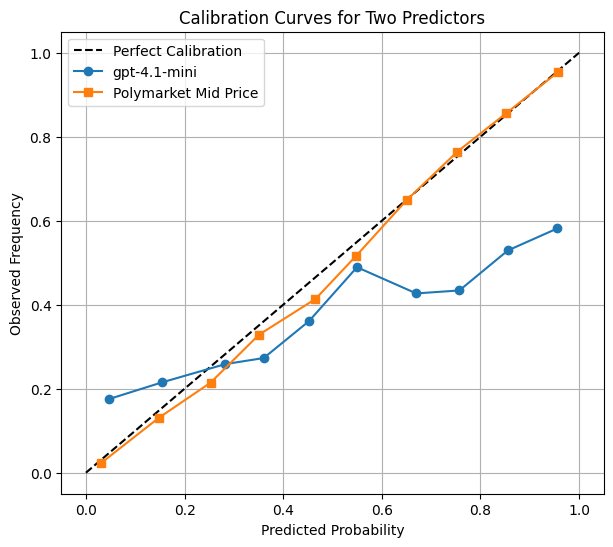

In [ ]:
## Generate calibration curves for the two predictors
from sklearn.calibration import calibration_curve

# Compute calibration curves
df_clean = eval_df.dropna(subset=['Price_Mid', 'PredProb', "EndOutcome"])

y_true = df_clean["EndOutcome"]
prob_A = df_clean['PredProb']
prob_B = df_clean['Price_Mid']

prob_true_A, prob_pred_A = calibration_curve(y_true, prob_A, n_bins=10)
prob_true_B, prob_pred_B = calibration_curve(y_true, prob_B, n_bins=10)

# Plot
plt.figure(figsize=(7, 6))

# Perfect calibration line
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")

# Predictor A
plt.plot(prob_pred_A, prob_true_A, marker="o", label="gpt-4.1-mini")

# Predictor B
plt.plot(prob_pred_B, prob_true_B, marker="s", label="Polymarket Mid Price")

plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curves for Two Predictors")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\eyhua\AppData\Local\Temp\ipykernel_24292\4160016640.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mid_brier_by_cat = df_clean.groupby("category").apply(
C:\Users\eyhua\AppData\Local\Temp\ipykernel_24292\4160016640.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_brier_by_cat = df_clean.groupby("category").apply(


Text(0.5, 1.0, 'Brier Score by Category')

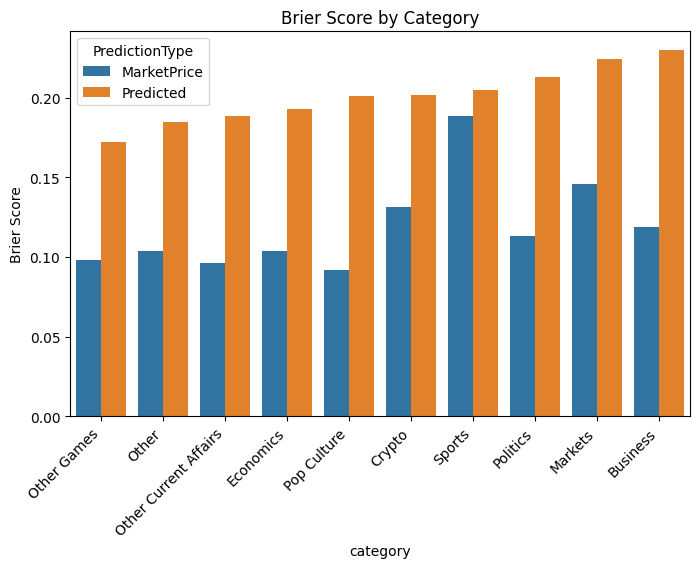

In [ ]:
#Generate plots of Brier score by categories
df_clean = eval_df.dropna(subset=["EndOutcome", "Price_Mid", "category"])

mid_brier_by_cat = df_clean.groupby("category").apply(
    lambda g: brier_score_loss(g["EndOutcome"], g["Price_Mid"])
).reset_index(name = 'MarketPrice')

df_clean = eval_df.dropna(subset=["PredProb", "Price_Mid", "category"])
pred_brier_by_cat = df_clean.groupby("category").apply(
    lambda g: brier_score_loss(g["EndOutcome"], g["PredProb"])
).reset_index(name = 'Predicted')

brier_comp = mid_brier_by_cat.merge(pred_brier_by_cat, on = 'category', how = 'left')
brier_comp = brier_comp.sort_values('Predicted')
brier_comp = pd.melt(brier_comp, id_vars = ['category'], value_name = 'Brier Score', var_name = 'PredictionType')

plt.figure(figsize=(8, 5))
sns.barplot(brier_comp, x = 'category', y = 'Brier Score', hue = 'PredictionType')

# Make x-axis labels fully visible
plt.xticks(rotation=45, ha='right')
plt.title("Brier Score by Category")


In [ ]:
## Lookahead Bias Study by splitting dataset into before and after model cutoff date
cutoff_date = pd.to_datetime('2024-06-01')

predprob_col = 'Price_Mid'
pred_col = 'PriceOutcome'

df_clean = eval_df[pd.to_datetime(eval_df['event_endDate']) < cutoff_date].dropna(subset=[pred_col, "EndOutcome"])
df_clean = eval_df[pd.to_datetime(eval_df['event_endDate']) >= cutoff_date].dropna(subset=[pred_col, "EndOutcome"])

print('Sample Size: ', len(df_clean))

y_true = df_clean["EndOutcome"]
y_prob = df_clean[predprob_col]
y_pred = df_clean[pred_col]

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_prob)
posrate = len(df_clean[df_clean["EndOutcome"] == 1]) / len(df_clean)
calib50 = len(df_clean[df_clean[predprob_col] > 0.5]) / len(df_clean)

cm = confusion_matrix(y_true, y_pred)

#Prob based metrics
logloss = log_loss(y_true, y_prob)
brier = brier_score_loss(y_true, y_prob)

metrics_table = pd.DataFrame({
    "Metric": [
        "Pos Rate",
        "Pos 50",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "ROC-AUC",
        "Log Loss",
        "Brier Score"
    ],
    "Value": [
        posrate,
        calib50,
        acc,
        prec,
        rec,
        f1,
        roc_auc,
        logloss,
        brier
    ]
})
display(metrics_table)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

Sample Size:  22270


,Metric,Value
0,Pos Rate,0.266322
1,Pos 50,0.215088
2,Accuracy,0.839470
3,Precision,0.745929
4,Recall,0.602428
5,F1 Score,0.666542
6,ROC-AUC,0.896346
7,Log Loss,0.347082
8,Brier Score,0.110835



Confusion Matrix:
 [[15122  1217]
 [ 2358  3573]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.93      0.89     16339
         1.0       0.75      0.60      0.67      5931

    accuracy                           0.84     22270
   macro avg       0.81      0.76      0.78     22270
weighted avg       0.83      0.84      0.83     22270

